In [9]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
import os

In [10]:
# Set up directory paths
# BASE_DIR = "fraud_detection_project"
DATA_DIR = os.path.join("../", "data")
OUTPUT_DIR = os.path.join("../", "outputs")
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [11]:
fraud_data = pd.read_csv(os.path.join(DATA_DIR, "Fraud_Data.csv"))
ip_data = pd.read_csv(os.path.join(DATA_DIR, "IpAddress_to_Country.csv"))
creditcard_data = pd.read_csv(os.path.join(DATA_DIR, "creditcard.csv"))

<Axes: xlabel='class', ylabel='count'>

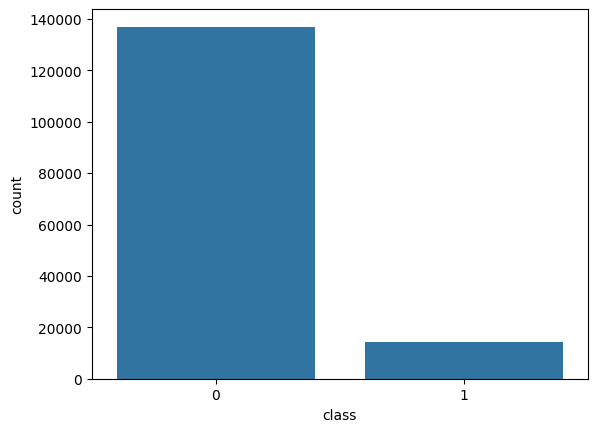

In [12]:
sns.countplot(data=fraud_data, x='class')

<Axes: xlabel='Class', ylabel='count'>

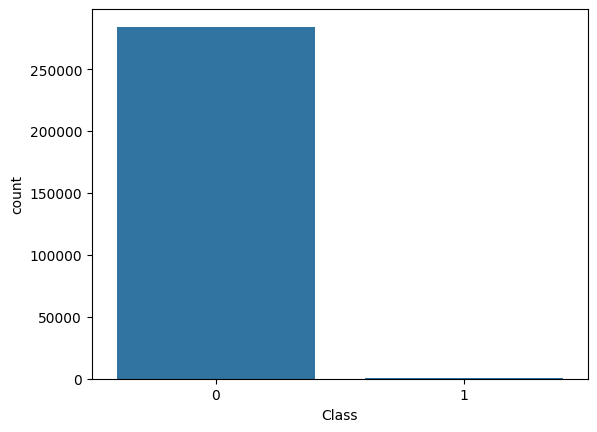

In [13]:

sns.countplot(data=creditcard_data, x='Class')

<Axes: xlabel='purchase_value', ylabel='Count'>

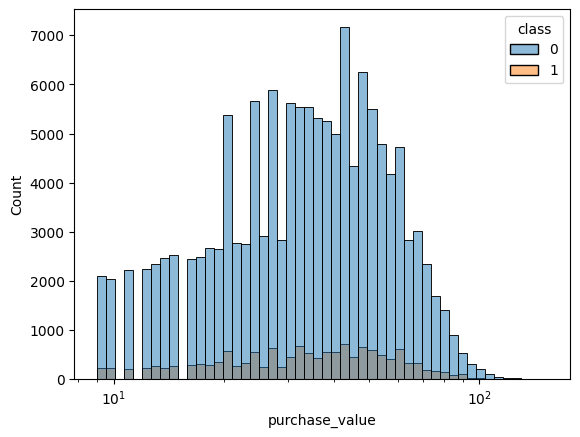

In [14]:
sns.histplot(data=fraud_data, x='purchase_value',
             hue='class', bins=50, log_scale=True)

<Axes: xlabel='Amount', ylabel='Count'>

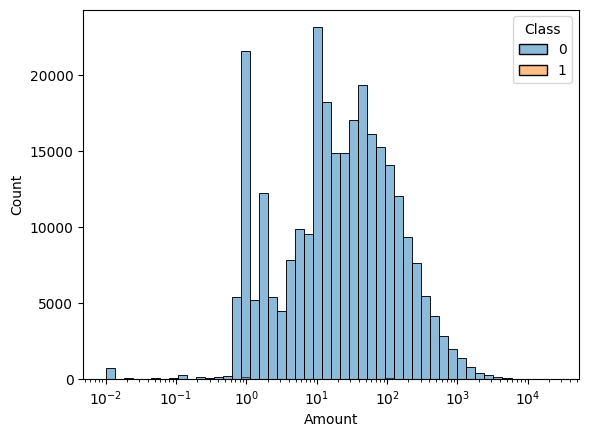

In [15]:
sns.histplot(data=creditcard_data, x='Amount',
             hue='Class', bins=50, log_scale=True)

In [16]:
display(fraud_data.head(), ip_data.head(), creditcard_data.head())

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [17]:
# Step 2: Handle Missing Values
def handle_missing_values(df, dataset_name):
    print(f"\nMissing values in {dataset_name}:\n", df.isnull().sum())
    # Impute numerical columns with median
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        df[col].fillna(df[col].median(), inplace=True)
    # Impute categorical columns with mode
    for col in df.select_dtypes(include=['object']).columns:
        df[col].fillna(df[col].mode()[0], inplace=True)
    print(
        f"\nMissing values after imputation in {dataset_name}:\n", df.isnull().sum())
    return df

In [18]:
def clean_data(df, dataset_name):
    # Remove duplicates
    initial_rows = df.shape[0]
    df.drop_duplicates(inplace=True)
    print(
        f"\nRemoved {initial_rows - df.shape[0]} duplicates from {dataset_name}")

    # Correct data types
    if dataset_name == "Fraud_Data":
        df['signup_time'] = pd.to_datetime(df['signup_time'])
        df['purchase_time'] = pd.to_datetime(df['purchase_time'])
    return df

In [19]:
def perform_eda(df, dataset_name):
    output_path = os.path.join(OUTPUT_DIR, f"{dataset_name}_eda")
    os.makedirs(output_path, exist_ok=True)

    # Univariate Analysis
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        plt.figure(figsize=(8, 6))
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col} in {dataset_name}")
        # plt.savefig(os.path.join(output_path, f"{col}_distribution.png"))
        plt.show()
        plt.close()

    # Bivariate Analysis (target vs features)
    if 'class' in df.columns:
        for col in df.select_dtypes(include=['float64', 'int64']).columns:
            if col != 'class':
                plt.figure(figsize=(8, 6))
                sns.boxplot(x='class', y=col, data=df)
                plt.title(f"{col} vs Class in {dataset_name}")
                # plt.savefig(os.path.join(output_path, f"{col}_vs_class.png"))
                plt.show()
                plt.close()

In [20]:
def merge_ip_data(fraud_data, ip_data):
    # Convert IP addresses to integer for merging
    fraud_data['ip_address'] = fraud_data['ip_address'].astype(int)
    ip_data['lower_bound_ip_address'] = ip_data['lower_bound_ip_address'].astype(
        int)
    ip_data['upper_bound_ip_address'] = ip_data['upper_bound_ip_address'].astype(
        int)

    # Merge datasets
    def map_ip_to_country(ip):
        match = ip_data[(ip_data['lower_bound_ip_address'] <= ip)
                        & (ip_data['upper_bound_ip_address'] >= ip)]
        return match['country'].iloc[0] if not match.empty else 'Unknown'

    fraud_data['country'] = fraud_data['ip_address'].apply(map_ip_to_country)
    return fraud_data

In [21]:
def feature_engineering(fraud_data):
    # Transaction frequency and velocity
    fraud_data['transaction_count'] = fraud_data.groupby(
        'user_id')['purchase_time'].transform('count')
    fraud_data['transaction_velocity'] = fraud_data.groupby('user_id')['purchase_time'].transform(
        lambda x: (x.max() - x.min()).total_seconds() / max(1, x.count()))

    # Time-based features
    fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour
    fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.dayofweek
    fraud_data['time_since_signup'] = (
        # in hours
        fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds() / 3600
    return fraud_data

In [22]:
def transform_data(df, dataset_name):
    if 'class' in df.columns:
        print(f"\nClass distribution in {dataset_name}:\n",
              df['class'].value_counts(normalize=True))
    else:
        print(
            f"\nWarning: 'class' column not found in {dataset_name}. Skipping class distribution analysis.")

    # Normalization and Scaling
    scaler = StandardScaler()
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop([
        'class'], errors='ignore')
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    # Encode Categorical Features (exclude high-cardinality 'device_id')
    categorical_cols = df.select_dtypes(include=['object']).columns
    if 'device_id' in categorical_cols:
        categorical_cols = categorical_cols.drop(
            'device_id')  # Exclude device_id
    if len(categorical_cols) > 0:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_data = encoder.fit_transform(df[categorical_cols])
        encoded_df = pd.DataFrame(
            encoded_data, columns=encoder.get_feature_names_out(categorical_cols))
        df = pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)
    return df

<Axes: xlabel='purchase_value', ylabel='class'>

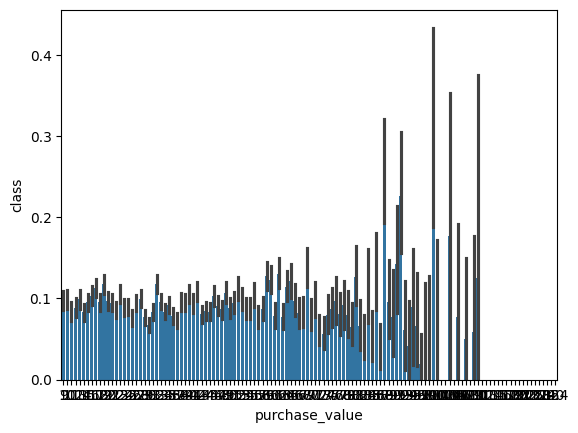

In [23]:
sns.barplot(data=fraud_data, x='purchase_value', y='class')


Removed 0 duplicates from Fraud_Data

Removed 1081 duplicates from creditcard


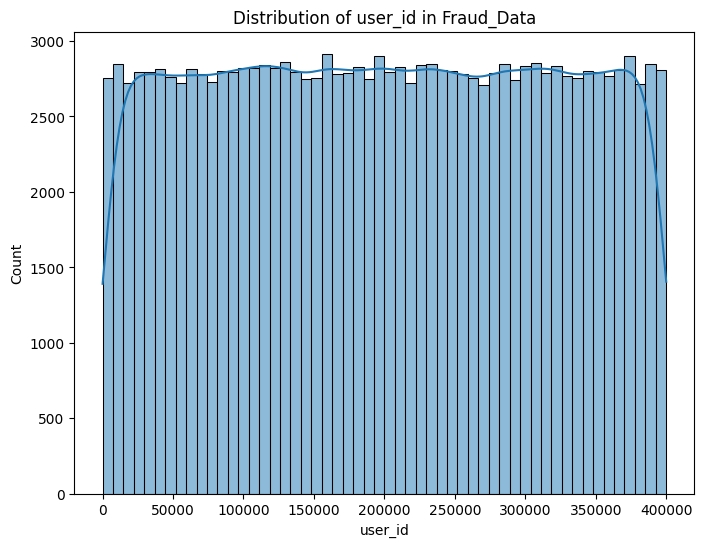

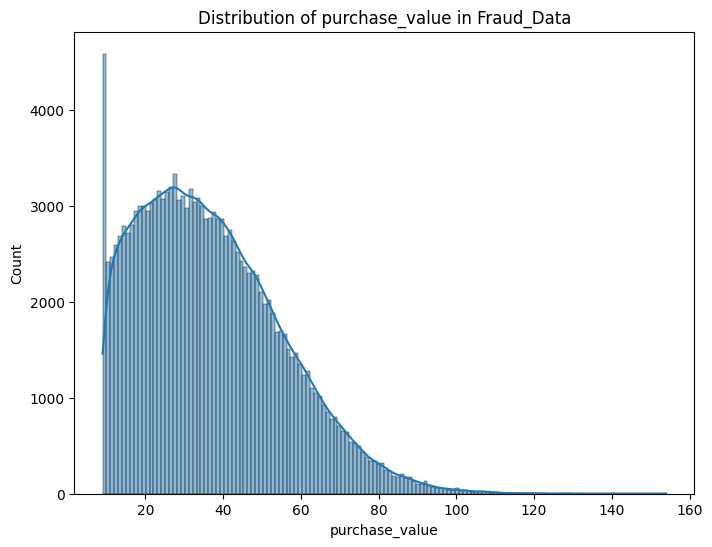

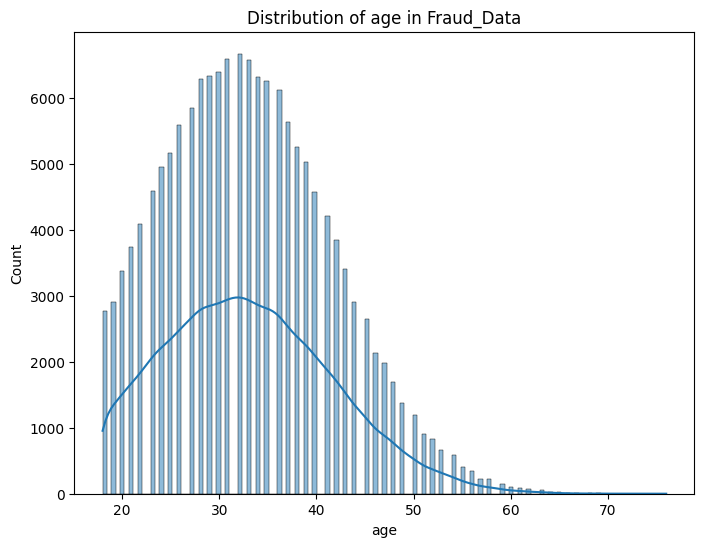

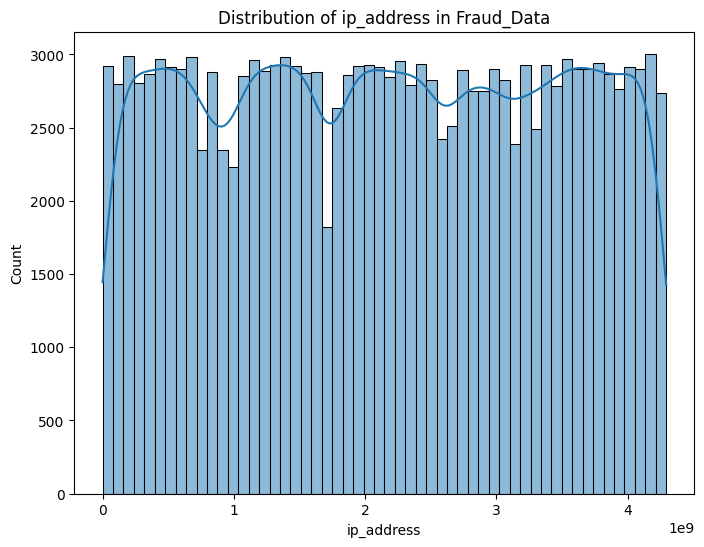

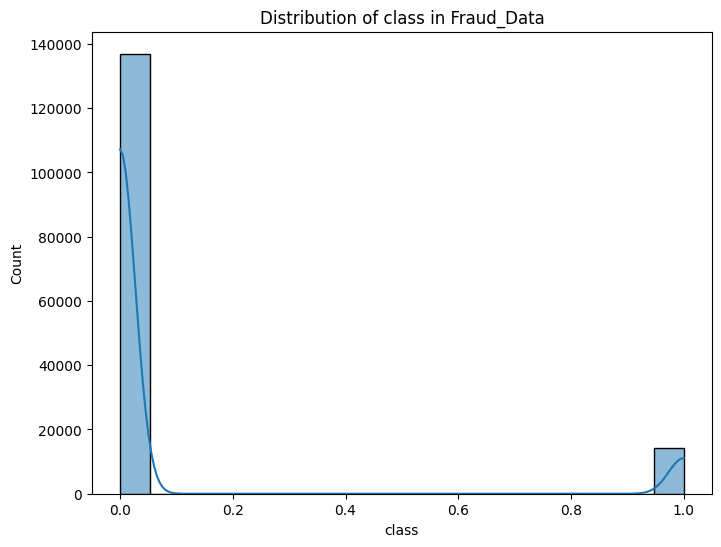

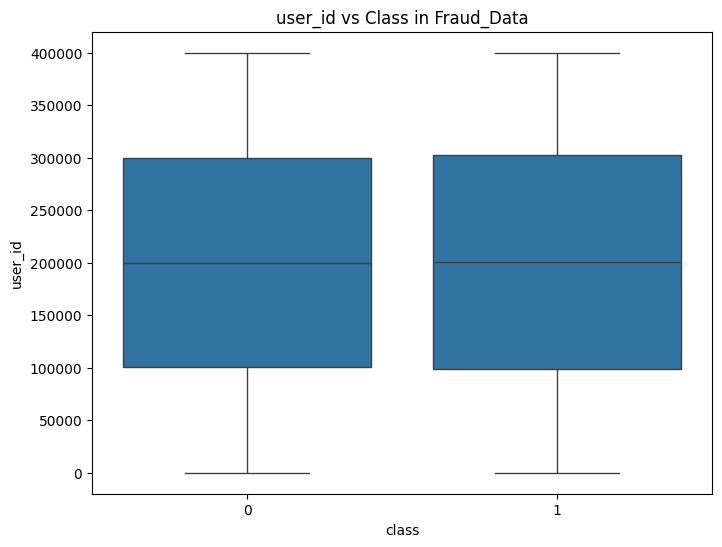

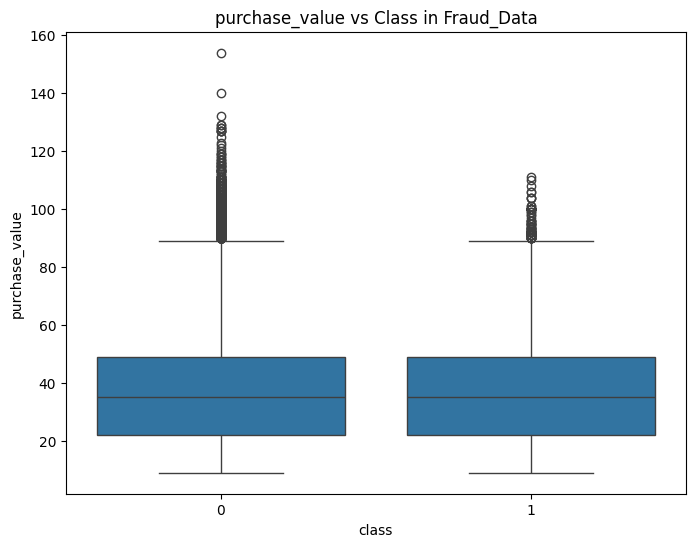

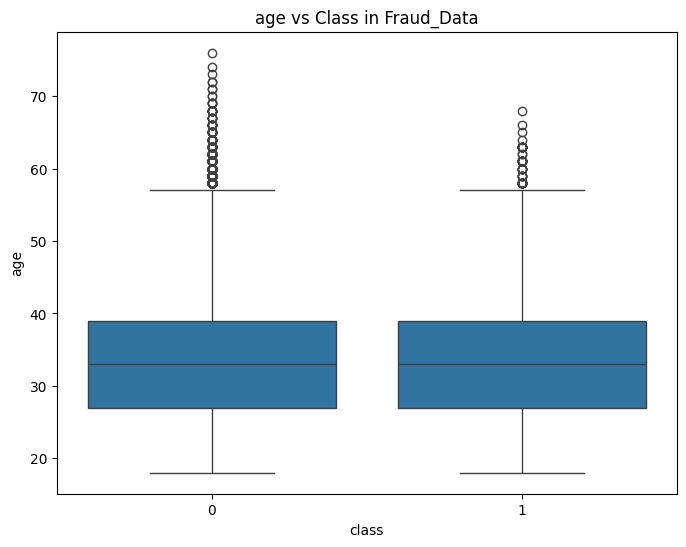

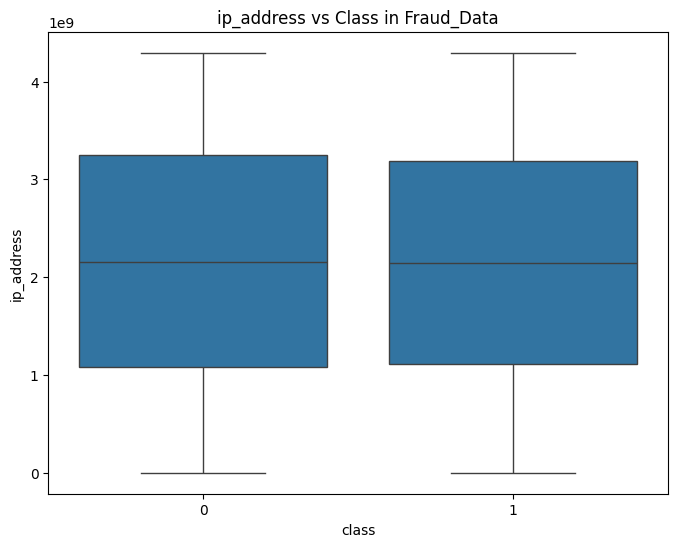

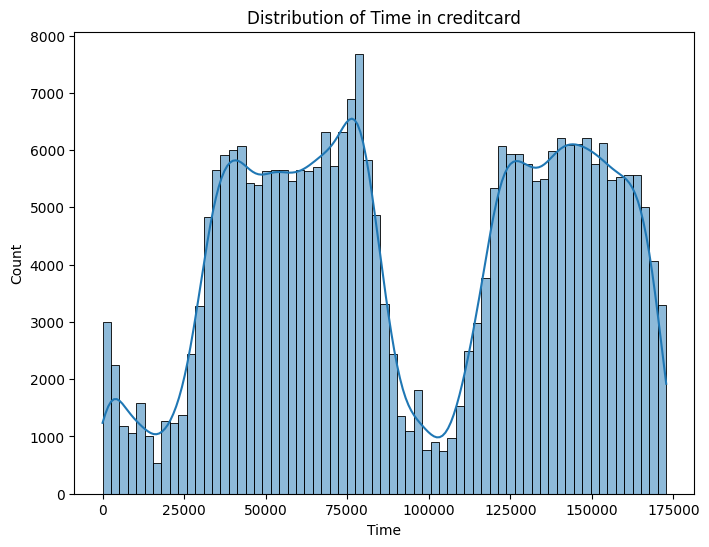

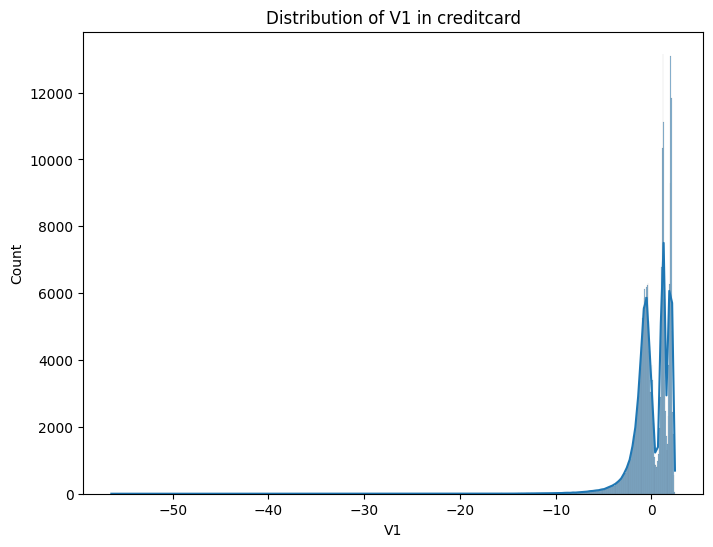

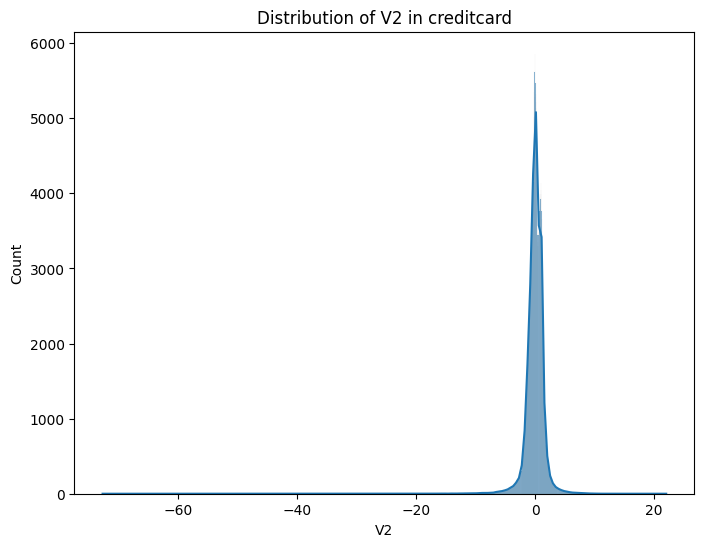

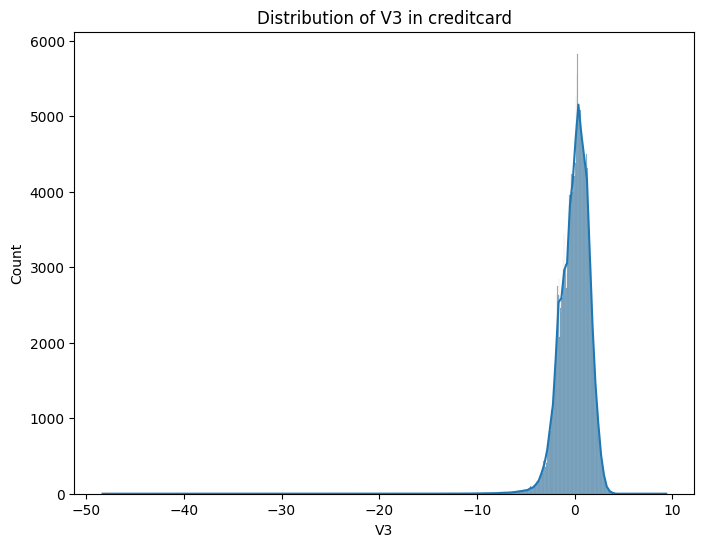

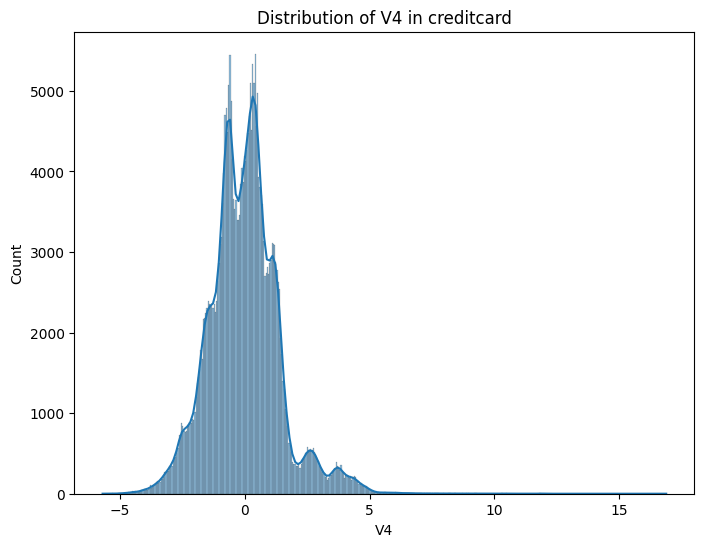

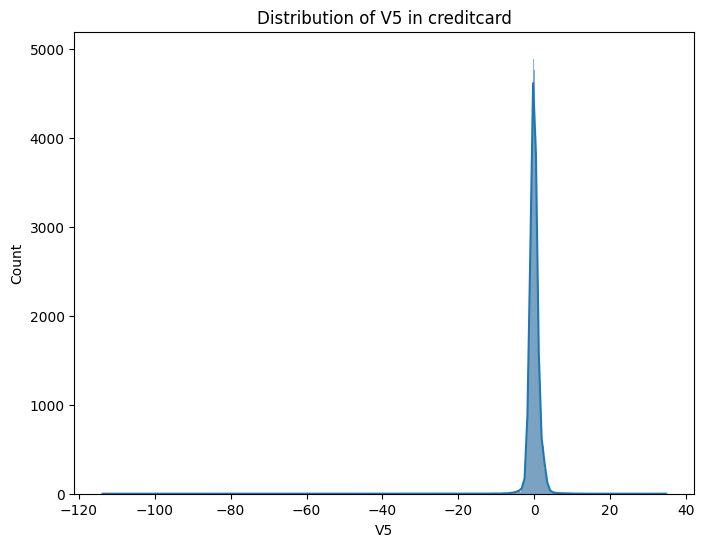

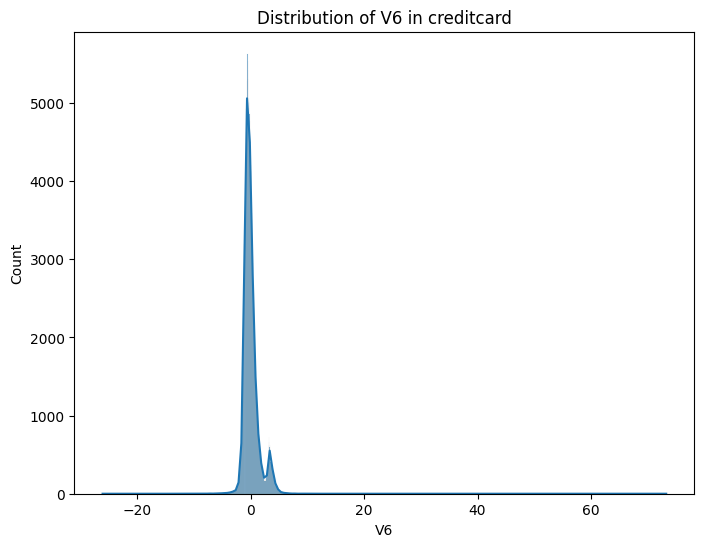

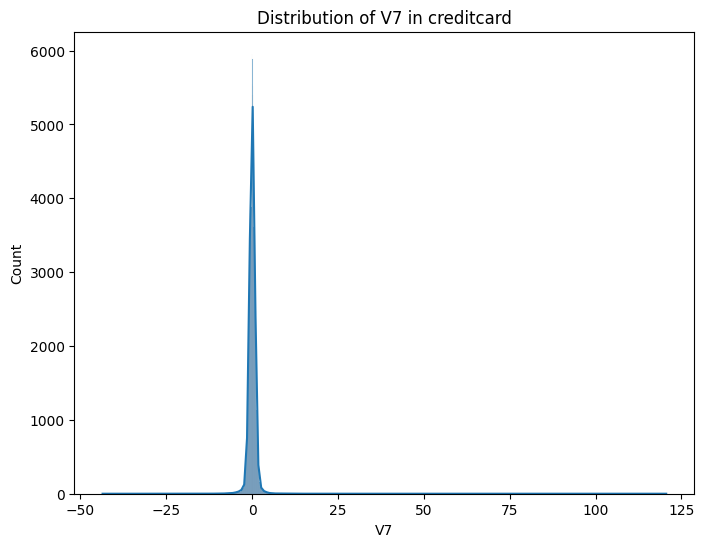

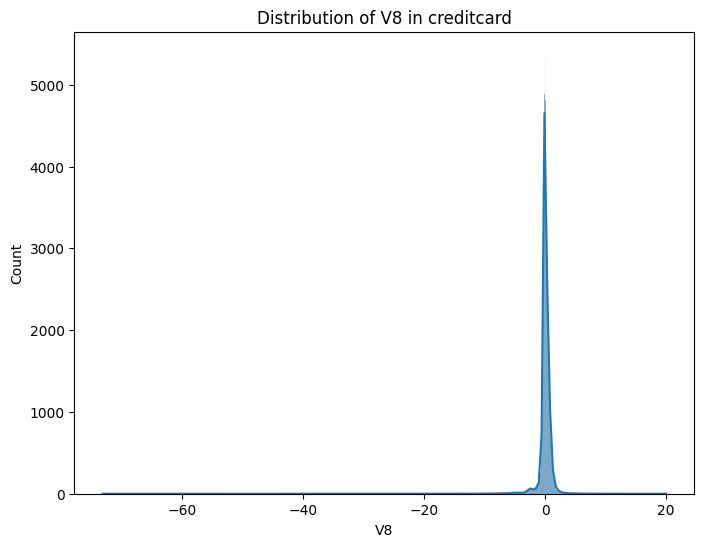

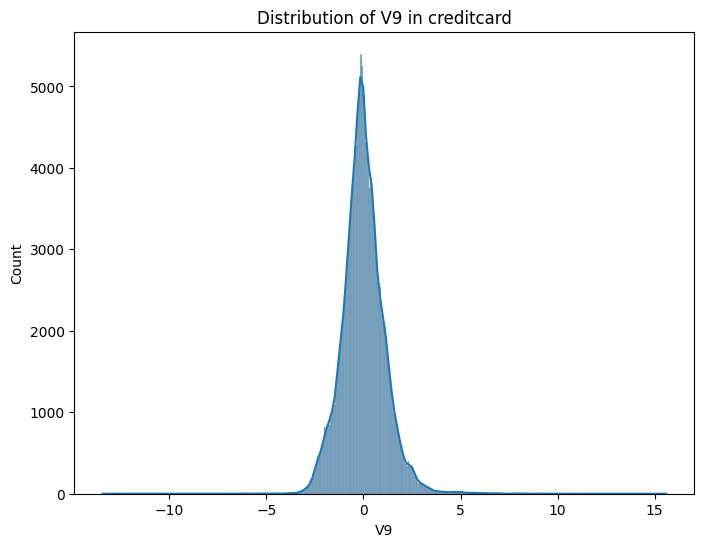

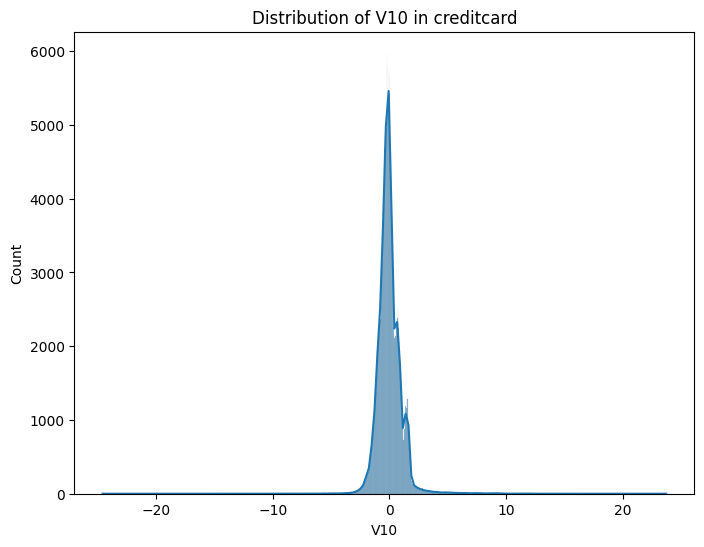

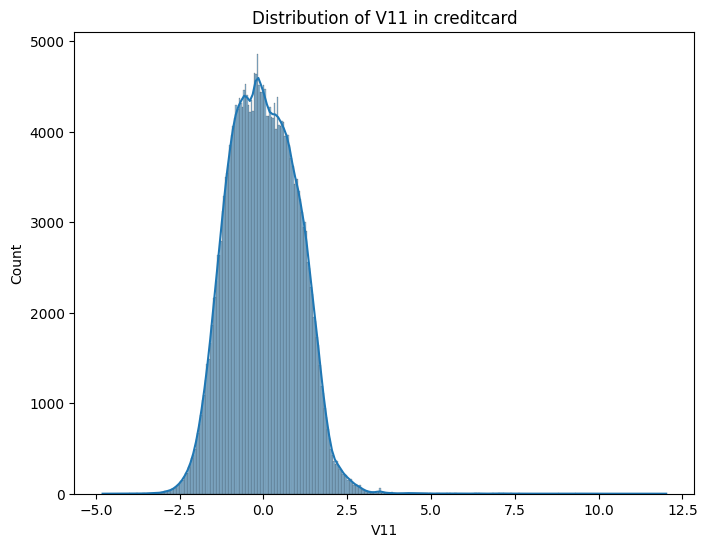

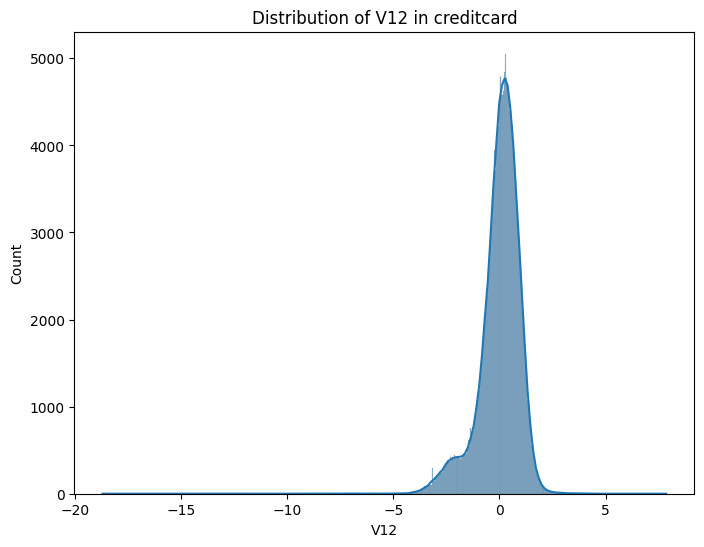

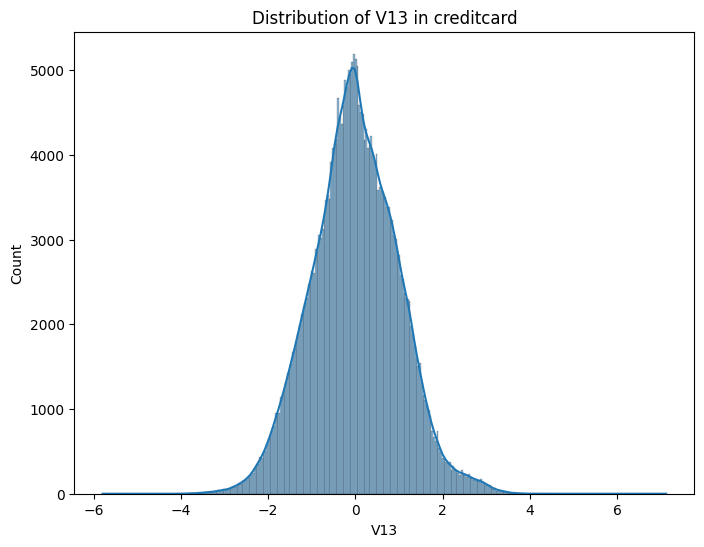

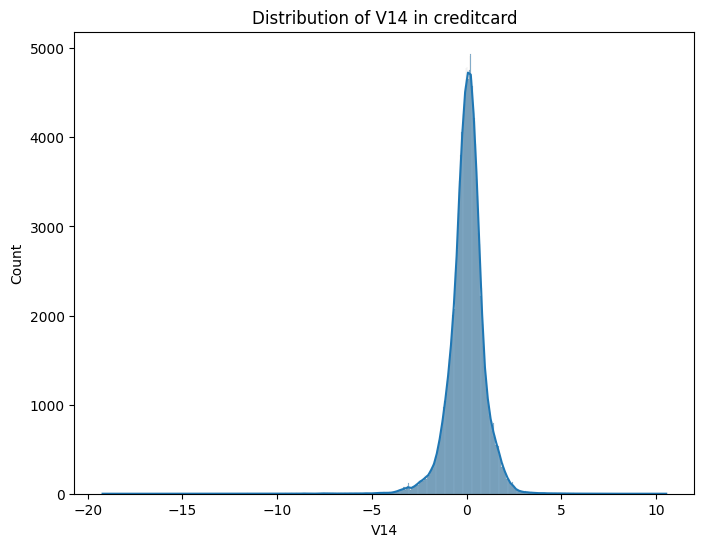

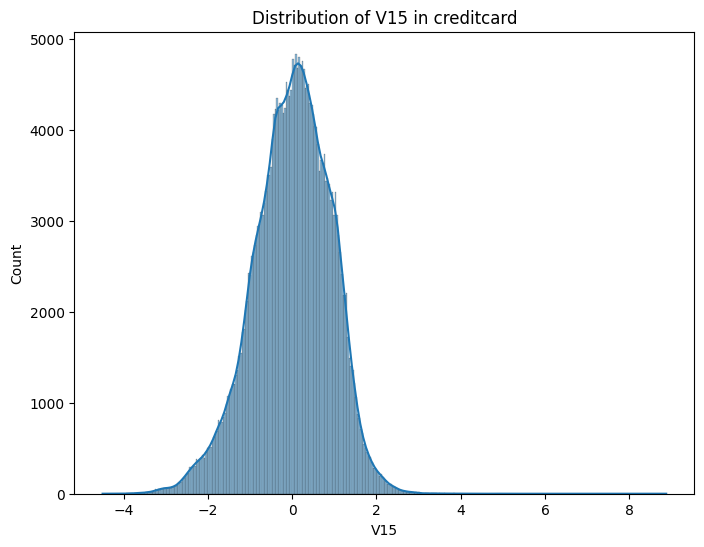

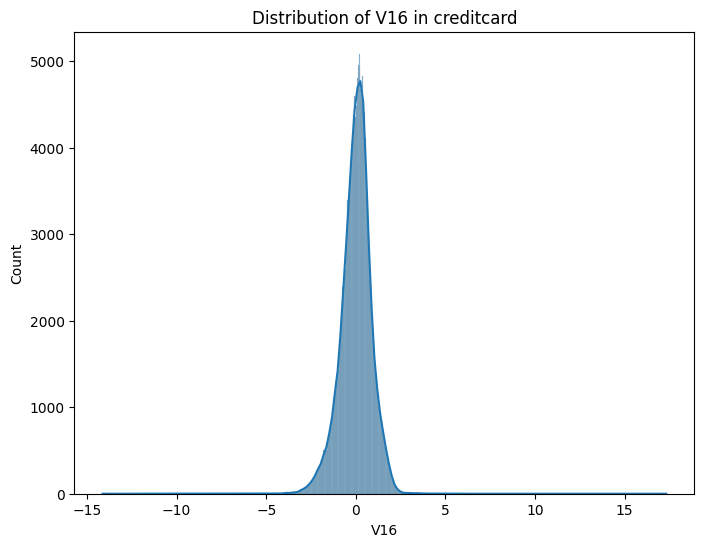

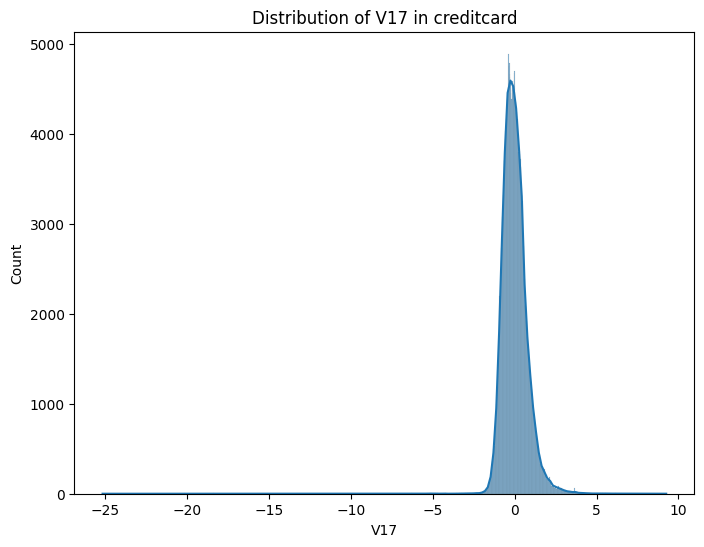

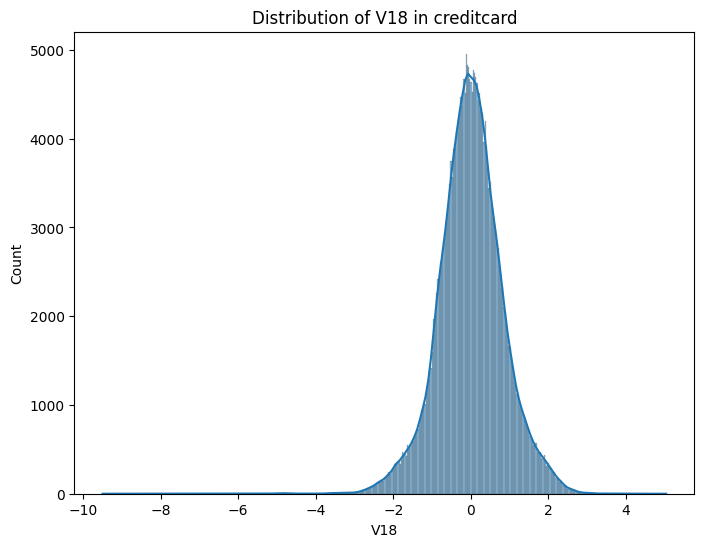

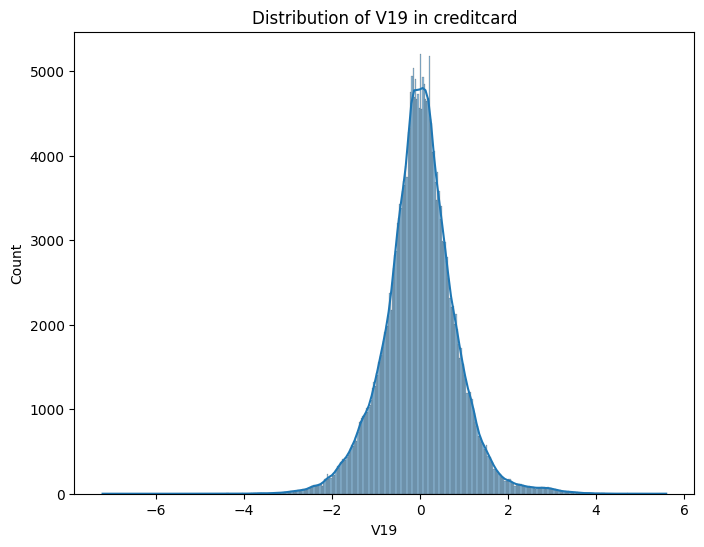

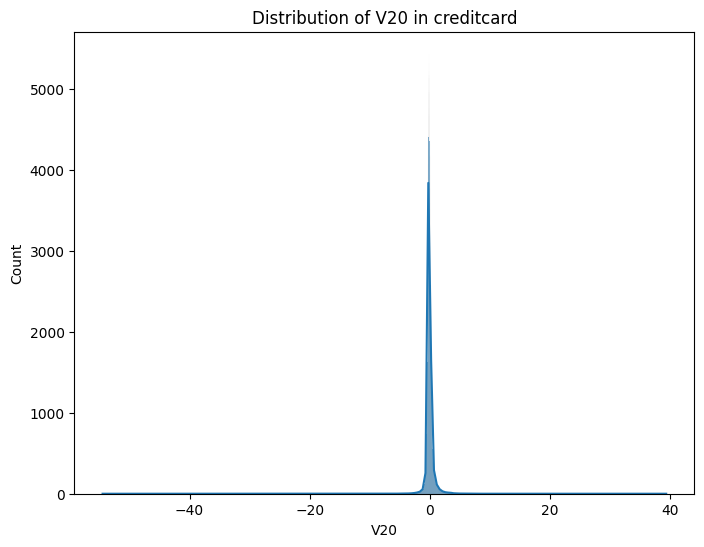

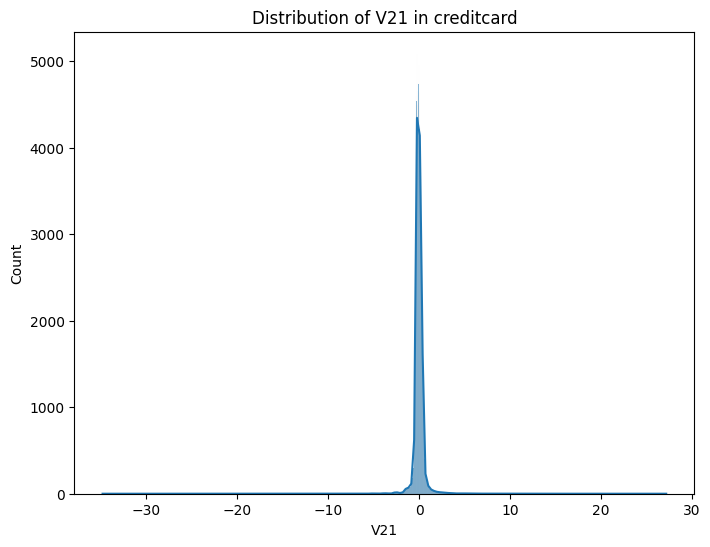

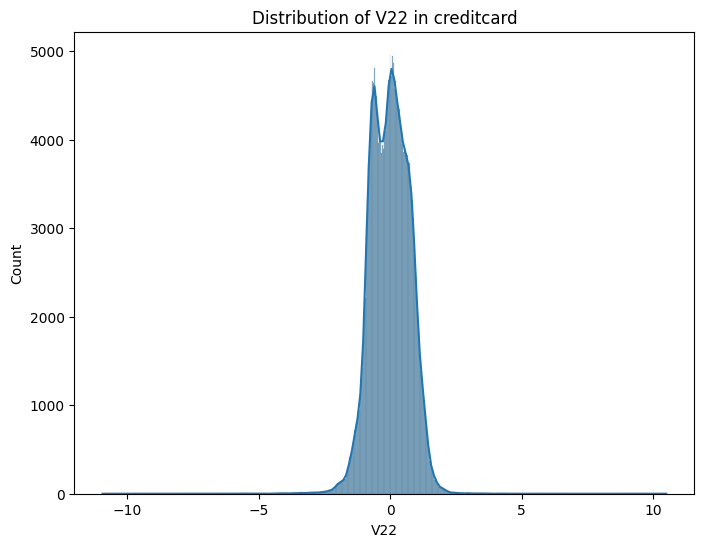

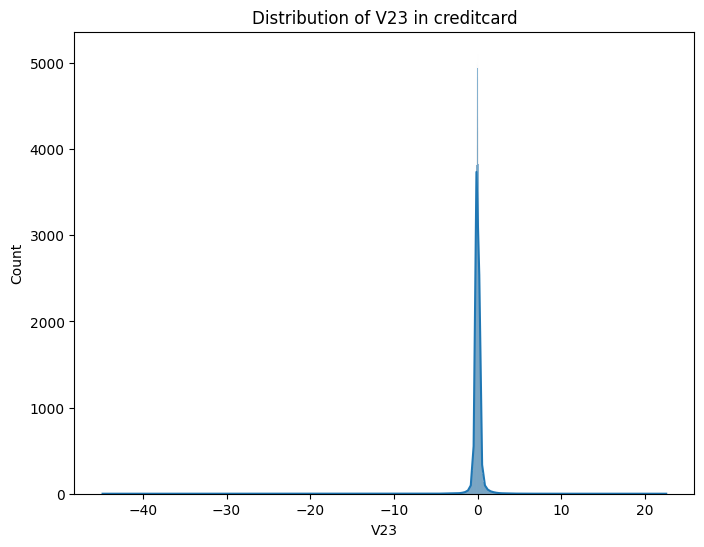

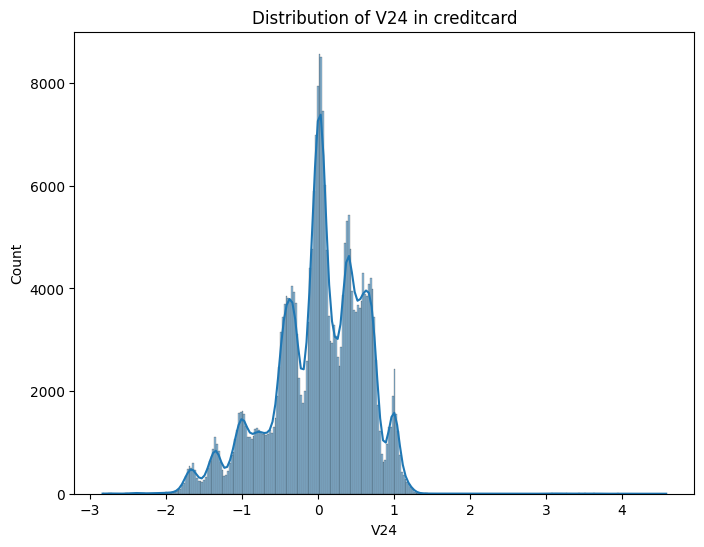

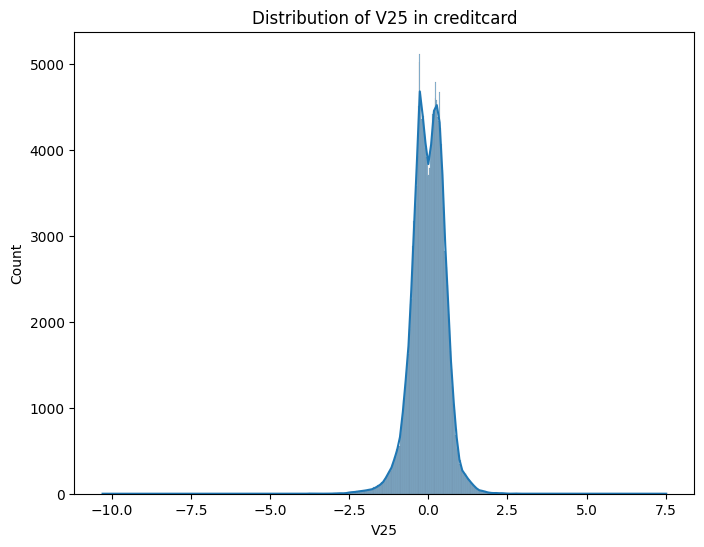

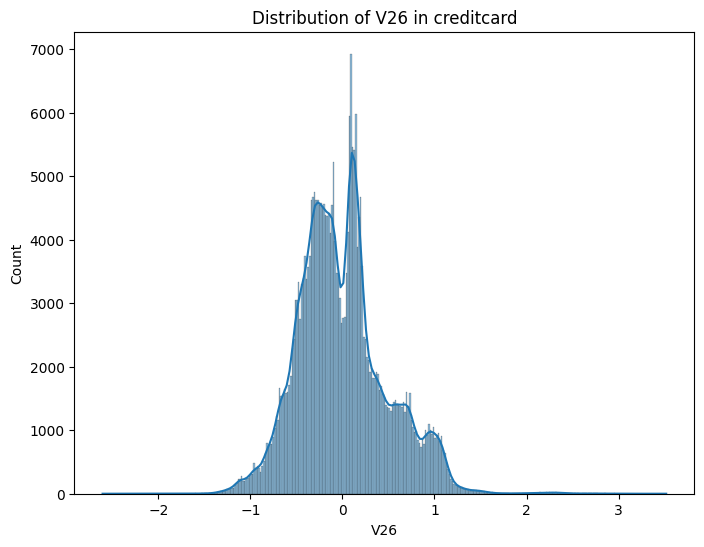

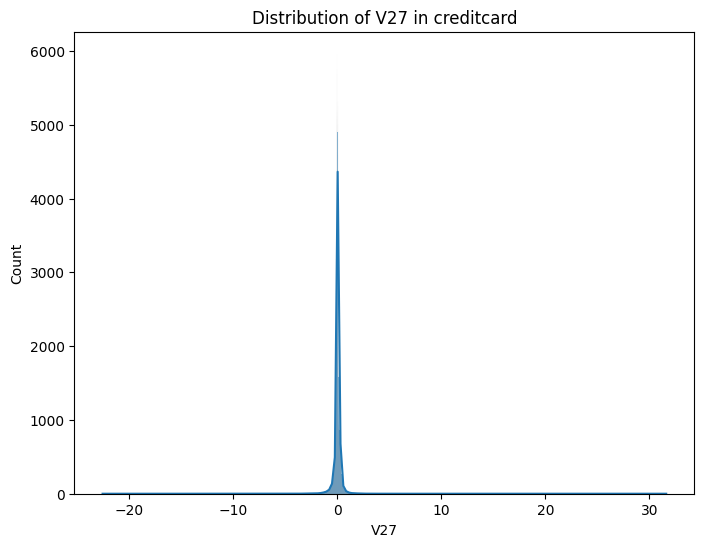

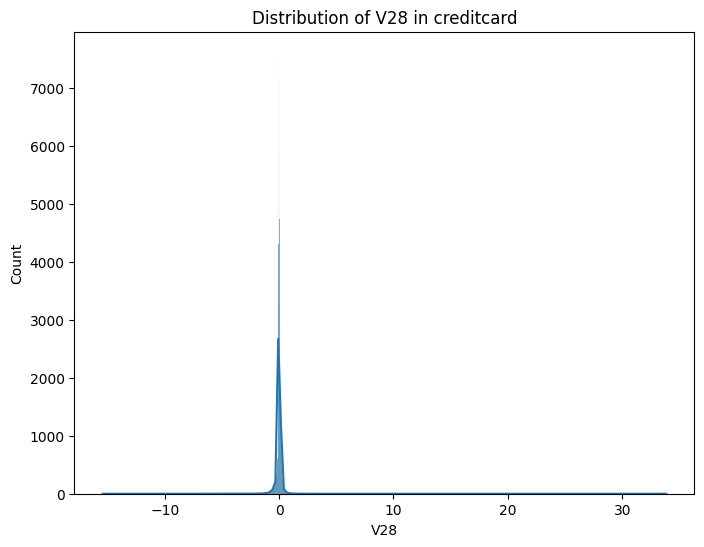

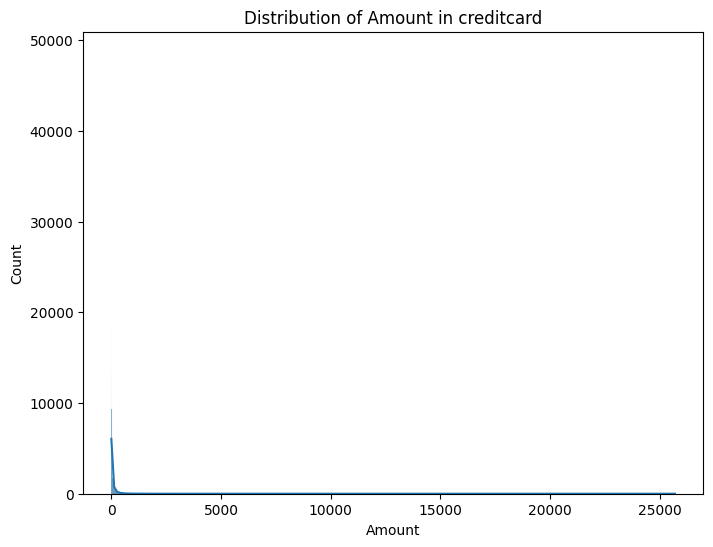

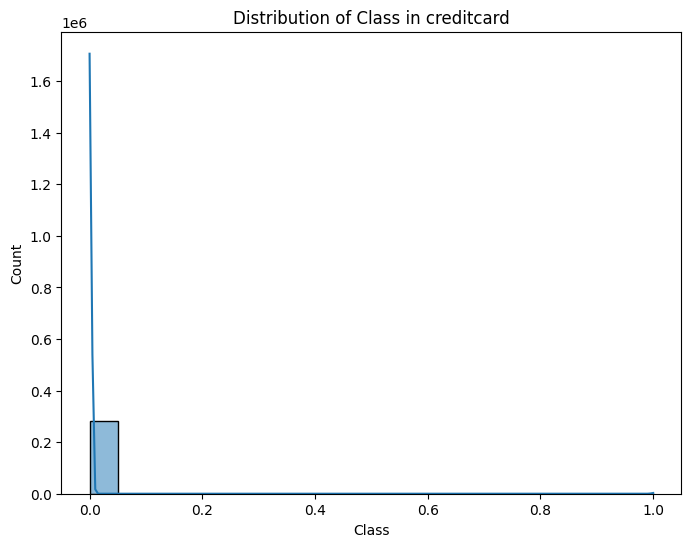


Class distribution in Fraud_Data:
 class
0    0.906354
1    0.093646
Name: proportion, dtype: float64



In [24]:
# Clean data
fraud_data = clean_data(fraud_data, "Fraud_Data")
creditcard_data = clean_data(creditcard_data, "creditcard")

# Perform EDA
perform_eda(fraud_data, "Fraud_Data")
perform_eda(creditcard_data, "creditcard")

# Merge datasets
fraud_data = merge_ip_data(fraud_data, ip_data)

# Feature engineering
fraud_data = feature_engineering(fraud_data)

# Data transformation
fraud_data = transform_data(fraud_data, "Fraud_Data")
creditcard_data = transform_data(creditcard_data, "creditcard")

# Save processed datasets
fraud_data.to_csv(os.path.join(
    OUTPUT_DIR, "processed_fraud_data.csv"), index=False)
creditcard_data.to_csv(os.path.join(
    OUTPUT_DIR, "processed_creditcard_data.csv"), index=False)